# 5.2：时间演化块消减算法

Time-Evolving Block Decimation (TEBD)

> References:
> * _Efficient classical simulation of slightly entangled quantum computations_
> * _Efficient simulation of one-dimensional quantum many-body systems_
> * _Infinite time-evolving block decimation algorithm beyond unitary evolution_

步骤：
1. 随机初始化MPS：$|\varphi\rangle$；
2. 计算虚时长度为$\tau$的局域虚时演化算符：$e^{-\tau\hat{H}(p)}$；
3. 演化MPS并归一化：$e^{-\tau\hat{H}}|\varphi\rangle \rightarrow |\varphi\rangle/Z$（$Z = \langle\varphi|\varphi\rangle$）：
   - 若MPS虚拟维数超过阈值（截断维数），则利用中心正交形式实现最优裁剪；
4. 若$|\varphi\rangle$收敛：
   1. 若$\tau$足够小，则返回计算结果，计算结束。
   2. 否则，减小$\tau$并回到步骤2。

## 计算技巧

### 将二体演化门写成两个三阶张量的缩并，方便后续计算

![tebd_evo_gate](./images/tebd_evo_gate.png)

不分解直接演化会导致 MPS 张量个数发生改变（如下图）；考虑到程序在处理长程耦合的通用性，我们这里不选择这种方式


![tebd_evo_step](./images/tebd_evo_step.png)

对演化算符分解后方便处理长程相互作用：演化前后MPS长度不变；

演化会破坏对应张量的正交性：对于第$l_1$与第$l_2$个自旋上的局域演化门，

作用之后，$l_{\text{L}}$与$l_{\text{R}}$上及其之间的所有张量失去正交性

![tebd_evo_step_detail](./images/tebd_evo_step_detailed.png)

> 演化区域中，张量失去正交性且虚拟指标维数增大

对于上图的左边来说

![tebd_evo_step_left](./images/tebd_evo_step_left.png)

> 缩并之后把 `g` 和 `b` 维度合并在一起
>
> 表达式是 $A'_{as(gb)} = \sum_{s'} A_{as'b}L_{sgs'}$
>

对于上图的中间张量来说

![tebd_evo_step_middle](./images/tebd_evo_step_middle.png)

> 相当于是张量和 $I$ 做直积之后合并维度，也就是
>
> $A'_{(ga)s(g'b)} = A_{asb}I_{gg'}$
>

对于上图的右边来说

![tebd_evo_step_right](./images/tebd_evo_step_right.png)

> 缩并之后把 `g` 和 `a` 维度合并在一起，相当于是
>
> $A^{\prime}_{(ga)sb} = \sum_{s^{\prime}} A_{as^{\prime}b}R_{sgs^{\prime}}$

In [1]:
# |default_exp algorithms.time_evolving_block_decimation
# |export
import torch
from einops import einsum, rearrange

In [2]:
from itertools import permutations
from time import time

In [3]:
tries = 1000
skip_perf_benchmark = True

# try two different ways to calculate the direct product of I and a
# Surprisingly, the einsum way is faster than the way in which no calculation is needed
for dim in [2, 4, 8, 16, 32, 64, 128]:
    if skip_perf_benchmark:
        break
    I = torch.eye(dim, dtype=torch.int32)
    a = torch.randn(3, 5, 7, dtype=torch.float32)
    start = time()
    for _ in range(tries):
        Ia_einsum = einsum(I, a, "g0 g1, a s b -> g0 a s g1 b")
        Ia_einsum = rearrange(Ia_einsum, "g0 a s g1 b -> (g0 a) s (g1 b)")
    end = time()
    einsum_time = end - start

    start = time()
    for _ in range(tries):
        a_ = a.unsqueeze(0).unsqueeze(0).repeat(dim, dim, 1, 1, 1)
        perms = permutations(range(dim), r=2)
        x, y = zip(*perms)
        x = torch.tensor(x)
        y = torch.tensor(y)
        a_[x, y] = 0.0
        a_[y, x] = 0.0
        Ia_no_calculation = rearrange(a_, "g0 g1 a s b -> (g0 a) s (g1 b)")
    end = time()
    no_calculation_time = end - start
    assert torch.allclose(Ia_no_calculation, Ia_einsum)

    print(
        f"dim={dim}, {einsum_time=}s, {no_calculation_time=}s, diff={no_calculation_time - einsum_time}s"
    )

将二体演化算符写成两个三阶张量的收缩，在这里，我们采取一种简单的分解方式，即

$G_{abcd} \stackrel{\text{permute}}{\longrightarrow} G_{abdc} \stackrel{\text{reshape (bd)}\rightarrow g}{\longrightarrow} (\text{gl})_{agc}$

$I_{bb'}I_{dd'} \stackrel{\otimes}{\longrightarrow} (gr)_{bb'dd'} \stackrel{\text{permute}}{\longrightarrow} (\text{gr})_{bb'd'd} \stackrel{\text{reshape (b'd')}\rightarrow g}{\longrightarrow} (\text{gr})_{bgd}$

也就是如下图

![tebd_op_to_tensors](./images/tebd_op_to_tensors.png)

In [4]:
op = torch.randn(2, 2, 2, 2, dtype=torch.complex64)
I = torch.eye(2, dtype=torch.int32)

gr = einsum(I, I, "b0 b1, d0 d1 -> b0 b1 d0 d1")
gr = rearrange(gr, "b0 b1 d0 d1 -> b0 (b1 d1) d0")

gl = rearrange(op, "a b c d -> a (b d) c")

product = einsum(gl, gr.to(gl.dtype), "a g c , b g d -> a b c d")

assert torch.allclose(product, op)

### 尽量少地移动正交中心；保持裁剪的最优性

策略要点：尽量少地移动正交中心；保持裁剪的最优性

1. 将正交中心以移动至$l_L$与$l_R$二者中距离当前正交中心最近的位置；
2. 演化后，从$l_L$或$l_R$出发，对整个演化区地张量做正交化变换（不裁剪）；
3. 当MPS处于正交中心形式后，通过移动中心的奇异值分解进行虚拟维数裁剪；
4. 正交化后的正交中心要尽可能地靠近下一次演化格点的位置。

> 例：
> 
> 演化前正交中心位于 $l_c = 4$，下一次的演化算符分别作用于自旋 1 与 2，再下一次的演化作用于自旋 5 与 6，则最优的中心正交化策略如下
>
> ![tebd_center_orthogonalization_example](./images/tebd_center_orthogonalization_example.png)
>
> 左图正交中心位置变化：4 → 2 → None → 1 → 2
>
> 2 → None 是演化步骤，1 → 2 是裁剪步骤
> 
>
> 下一步演化位置为5与6（若设再下一步演化位置为0和1），则对应的正交中心位置变化：
> 2 → 5 → None → 6 → 5
>
> 5 → None 是演化步骤，6 → 5 是裁剪步骤
>

强调：非中心正交形式下不裁剪，否则不能达到最优裁剪

## Code

In [5]:
# |export
from typing import List
from tensor_network.mps.modules import MPS
from tensor_network.utils.mapping import view_gate_matrix_as_tensor, view_gate_tensor_as_matrix
from tensor_network.utils.checking import check_quantum_gate


def evolve_gate_2body(
    mps_local_tensors: List[torch.Tensor], gl: torch.Tensor, gr: torch.Tensor, p0: int, p1: int
):
    # gl - (a, g, c)
    # gr - (b, g, d)
    assert p0 < p1
    assert gl.shape[1] == gr.shape[1]
    g_dim = gl.shape[1]
    local_tensors = mps_local_tensors

    local_tensor_left = local_tensors[p0]
    local_tensor_left = einsum(
        local_tensor_left,
        gl,
        "left physical_c right, new_physical g physical_c -> left new_physical g right",
    )
    local_tensors[p0] = rearrange(
        local_tensor_left, "left new_physical g right -> left new_physical (g right)"
    )

    local_tensor_right = local_tensors[p1]
    local_tensor_right = einsum(
        local_tensor_right,
        gr,
        "left physical right, new_physical g physical -> g left new_physical right",
    )
    local_tensors[p1] = rearrange(
        local_tensor_right, "g left new_physical right -> (g left) new_physical right"
    )

    I = torch.eye(g_dim, dtype=torch.int32, device=mps_local_tensors[0].device)

    for idx in range(p0 + 1, p1):
        local_tensor_i = local_tensors[idx]
        new_local_tensor_i = einsum(
            I, local_tensor_i, "g0 g1, left physical right -> g0 left physical g1 right"
        )
        local_tensors[idx] = rearrange(
            new_local_tensor_i, "g0 left physical g1 right -> (g0 left) physical (g1 right)"
        )

    return local_tensors

In [6]:
import tensor_network.setup_ref_code_import as _
from Library.MatrixProductState import MPS_tebd
from tensor_network.tensor_gates.functional import apply_gate
from tensor_network.mps.modules import MPSType
from itertools import combinations

In [7]:
# test evolve_gate_2body
cpu = torch.device("cpu")
skip_test_evolve_gate_2body = True

for _ in range(10):
    if skip_test_evolve_gate_2body:
        break
    for length in range(2, 10):
        mps = MPS(
            length=length,
            physical_dim=2,
            virtual_dim=10,
            mps_type=MPSType.Open,
            dtype=torch.complex128,
            device=cpu,
            requires_grad=False,
        )
        mps.center_orthogonalization_(0, mode="qr", normalize=True)
        mps.normalize_()
        global_tensor = mps.global_tensor()
        gate = torch.randn(2, 2, 2, 2, dtype=mps.dtype, device=cpu)
        gate = gate / gate.norm()
        I = torch.eye(mps.physical_dim, dtype=torch.int32, device=cpu)
        gr = einsum(I, I, "b0 b1, d0 d1 -> b0 b1 d0 d1")
        gr = rearrange(gr, "b0 b1 d0 d1 -> b0 (b1 d1) d0").to(dtype=mps.dtype)
        gl = rearrange(gate, "a b c d -> a (b d) c")
        for target_qubits in combinations(range(mps.length), 2):
            new_mps_local_tensors = evolve_gate_2body(
                mps.local_tensors, gl, gr, target_qubits[0], target_qubits[1]
            )
            new_global_tensor = MPS(mps_tensors=new_mps_local_tensors).global_tensor()
            global_tensor_ref = apply_gate(
                quantum_state=global_tensor, gate=gate, target_qubit=list(target_qubits)
            )
            assert torch.allclose(new_global_tensor, global_tensor_ref), f"""
{length=}
{new_global_tensor.flatten()}
{global_tensor_ref.flatten()}
L2-Norm = {torch.norm(new_global_tensor - global_tensor_ref)}
"""
            local_tensors = mps.local_tensors
            local_tensors = [t.clone() for t in local_tensors]
            mps_ref = MPS_tebd(tensors=local_tensors, para={"dtype": mps.dtype, "device": cpu})
            mps_ref.evolve_gate_2body_LR(gl, gr, target_qubits)
            for local_tensor, local_tensor_ref in zip(new_mps_local_tensors, mps_ref.tensors):
                assert torch.allclose(local_tensor, local_tensor_ref), f"""
{length=}
{local_tensor.flatten()}
{local_tensor_ref.flatten()}
L2-Norm = {torch.norm(local_tensor - local_tensor_ref)}
"""

In [8]:
from fastcore.basics import patch
from tensor_network.quantum_state.functional import calc_reduced_density_matrix

In [9]:
# |export mps.modules
from einops import rearrange


@patch
def two_body_reduced_density_matrix_(
    self: MPS, qubit_idx0: int, qubit_idx1: int, return_matrix: bool = False
) -> torch.Tensor:
    assert 0 <= qubit_idx0 < qubit_idx1
    self.center_orthogonalization_(qubit_idx0, mode="qr", normalize=True)

    tensor_left = self._mps[qubit_idx0]
    product = einsum(
        tensor_left.conj(),
        tensor_left,
        "left physical_conj right_conj, left physical right -> physical_conj physical right_conj right",
    )

    for idx in range(qubit_idx0 + 1, qubit_idx1):
        tensor_i = self._mps[idx]
        product = einsum(
            product,
            tensor_i.conj(),
            tensor_i,
            "i0_physical_conj i0_physical left_conj left, left_conj physical right_conj, left physical right -> i0_physical_conj i0_physical right_conj right",
        )

    tensor_right = self._mps[qubit_idx1]
    rdm = einsum(
        product,
        tensor_right.conj(),
        tensor_right,
        "i0_physical_conj i0_physical left_conj left, left_conj i1_physical_conj right, left i1_physical right -> i0_physical i1_physical i0_physical_conj i1_physical_conj ",
    )

    if return_matrix:
        return rearrange(rdm, "a b c d -> (a b) (c d)")
    else:
        return rdm

In [10]:
# test two_body_reduced_density_matrix_
length = 4
cpu = torch.device("cpu")
skip_test_two_body_reduced_density_matrix = False

for _ in range(5):
    if skip_test_two_body_reduced_density_matrix:
        break
    for length in range(2, 10):
        mps = MPS(
            length=length,
            physical_dim=2,
            virtual_dim=10,
            mps_type=MPSType.Open,
            dtype=torch.complex128,
            device=cpu,
            requires_grad=False,
        )
        mps.center_orthogonalization_(0, mode="qr", normalize=True)
        for target_qubits in combinations(range(mps.length), 2):
            rdm = mps.two_body_reduced_density_matrix_(
                target_qubits[0], target_qubits[1], return_matrix=False
            )

            rdm0 = einsum(rdm, "ket0 kb1 bra0 kb1 -> ket0 bra0")
            rdm0_ref = mps.one_body_reduced_density_matrix(
                idx=target_qubits[0], do_tracing=False, inplace_mutation=False
            )
            assert torch.allclose(rdm0, rdm0_ref)

            global_tensor = mps.global_tensor()
            rdm_mat = rearrange(rdm, "a b c d -> (a b) (c d)")
            rdm_ref = calc_reduced_density_matrix(global_tensor, list(target_qubits))
            assert torch.allclose(rdm_mat, rdm_ref), f"rdm: {rdm}, rdm_ref: {rdm_ref}"

            mps_tebd = MPS_tebd(tensors=mps.local_tensors, para={"dtype": mps.dtype, "device": cpu})
            mps_tebd.center = mps.center
            rdm_tebd = mps_tebd.two_body_RDM(list(target_qubits))
            assert torch.allclose(rdm_tebd, rdm_mat.T)  # due to a bug in MPS_tebd.two_body_RDM

In [11]:
# |export
from typing import Literal


def direction_to_next_center(
    l0: int, r0: int, l1: int, r1: int
) -> Literal["right-to-left", "left-to-right"]:
    l_min = min([abs(l0 - l1), abs(l0 - r1)])
    r_min = min([abs(r0 - l1), abs(r0 - r1)])
    # TODO: check if this is correct
    if l_min < r_min:
        return "right-to-left"
    else:
        return "left-to-right"


def calculate_mps_local_energies(
    mps: MPS, hamiltonians: List[torch.Tensor], positions: List[List[int]] | torch.Tensor
) -> torch.Tensor:
    if len(hamiltonians) == 1:
        hamiltonians = hamiltonians * len(positions)

    assert len(hamiltonians) == len(positions), (
        f"len(hamiltonians): {len(hamiltonians)}, len(positions): {len(positions)}"
    )
    local_energies = []
    for pos, hamiltonian in zip(positions, hamiltonians):
        assert len(pos) == 2, "Only support 2-body interaction for now"
        rdm = mps.two_body_reduced_density_matrix_(pos[0], pos[1], return_matrix=True)
        local_energies.append(einsum(view_gate_tensor_as_matrix(hamiltonian), rdm, "a b, b a ->"))

    return torch.stack(local_energies)

In [12]:
# test calculate_mps_local_energies
from tensor_network.tensor_gates.hamiltonians import heisenberg

cpu = torch.device("cpu")
skip_test_calculate_mps_local_energies = True

for _ in range(10):
    if skip_test_calculate_mps_local_energies:
        break
    for length in range(2, 10):
        mps = MPS(
            length=length,
            physical_dim=2,
            virtual_dim=10,
            mps_type=MPSType.Open,
            dtype=torch.complex128,
            device=cpu,
            requires_grad=False,
        )
        mps.center_orthogonalization_(0, mode="qr", normalize=True)
        mps.normalize_()
        hamiltonian = heisenberg(jx=1, jy=1, jz=1, double_precision=False).to(
            device=mps.device, dtype=mps.dtype
        )
        for target_qubits in combinations(range(mps.length), 2):
            local_tensors = [t.clone() for t in mps.local_tensors]
            ref_mps = MPS_tebd(tensors=local_tensors, para={"dtype": mps.dtype, "device": cpu})
            local_energies = calculate_mps_local_energies(mps, [hamiltonian], [target_qubits])
            local_energies_ref = ref_mps.calculate_local_energies([hamiltonian], [target_qubits])
            assert torch.allclose(local_energies, local_energies_ref)

In [13]:
# |export

from tensor_network.mps.functional import orthogonalize_arange
from typing import Tuple
from tqdm.auto import tqdm
import tensor_network.setup_ref_code_import as _
from Library.MatrixProductState import MPS_tebd


def tebd(
    hamiltonians: torch.Tensor | List[torch.Tensor],
    positions: torch.Tensor | List[List[int]],
    mps: MPS,
    tau: float,
    iterations: int,
    calc_observation_iters: int,
    e0_eps: float,
    tau_min: float,
    least_iters_for_tau: int,
    max_virtual_dim: int,
    progress_bar_kwargs: dict = {},
) -> Tuple[MPS, torch.Tensor]:
    device = mps.device
    dtype = mps.dtype

    if isinstance(positions, List):
        positions = torch.tensor(positions, device=device, dtype=torch.long)
    else:
        assert isinstance(positions, torch.Tensor)
    assert torch.all(positions[:, 0] < positions[:, 1])

    assert positions.ndim == 2  # (interaction_num, gate_apply_qubit_num)
    interaction_num, gate_apply_qubit_num = positions.shape
    assert gate_apply_qubit_num == 2, "Only support 2-body interaction for now"
    if isinstance(hamiltonians, torch.Tensor):
        if hamiltonians.ndim == 2 * gate_apply_qubit_num:
            hamiltonians = [hamiltonians]
        elif hamiltonians.ndim == 2 * gate_apply_qubit_num + 1:
            assert hamiltonians.shape[0] == interaction_num
            hamiltonians = [hamiltonians[i] for i in range(interaction_num)]
        else:
            raise ValueError(f"Invalid hamiltonians shape: {hamiltonians.shape}")
    elif isinstance(hamiltonians, List):
        assert len(hamiltonians) == interaction_num
        for h in hamiltonians:
            assert h.ndim == 2 * gate_apply_qubit_num
    else:
        raise ValueError(f"Invalid hamiltonians type: {type(hamiltonians)}")

    hamiltonians = [h.to(device=device) for h in hamiltonians]
    for h in hamiltonians:
        check_quantum_gate(h, num_qubits=gate_apply_qubit_num)

    assert 1.0 > tau >= 0.0 and 1.0 > tau_min >= 0.0
    assert iterations >= 0 and calc_observation_iters >= 0 and least_iters_for_tau >= 1
    assert max_virtual_dim >= 1

    mps.center_orthogonalization_(
        positions[0, -1].item(), mode="svd", truncate_dim=max_virtual_dim, normalize=False
    )
    mps.normalize_()

    gates = [
        view_gate_matrix_as_tensor(torch.matrix_exp(-tau * view_gate_tensor_as_matrix(h)))
        for h in hamiltonians
    ]

    I = torch.eye(mps.physical_dim, dtype=torch.int32, device=device)
    gr = einsum(I, I, "b0 b1, d0 d1 -> b0 b1 d0 d1")
    gr = rearrange(gr, "b0 b1 d0 d1 -> b0 (b1 d1) d0").to(dtype=dtype)  # (b, g, d)

    inversed_temperatur = 0.0
    iters_for_tau = 0
    local_energies = 0.0

    for t in tqdm(range(iterations), **progress_bar_kwargs):
        for p, pos in enumerate(positions):
            p_left, p_right = pos.tolist()

            if abs(mps.center - p_left) < abs(mps.center - p_right):
                mps.center_orthogonalization_(p_left, mode="qr")
            else:
                mps.center_orthogonalization_(p_right, mode="qr")

            gate = gates[p] if len(gates) > 1 else gates[0]
            gl = rearrange(gate, "a b c d -> a (b d) c")  # (a, g, c)
            mps_local_tensors = evolve_gate_2body(mps.local_tensors, gl, gr, p_left, p_right)

            if p == interaction_num - 1:
                pos_next = positions[0]
            else:
                pos_next = positions[p + 1]

            direction = direction_to_next_center(p_left, p_right, pos_next[0], pos_next[1])
            if direction == "right-to-left":
                mps_local_tensors = orthogonalize_arange(
                    mps_tensors=mps_local_tensors,
                    start_idx=p_right,
                    end_idx=p_left,
                    mode="qr",
                    normalize=False,
                )

                mps_local_tensors = orthogonalize_arange(
                    mps_tensors=mps_local_tensors,
                    start_idx=p_left,
                    end_idx=p_right,
                    mode="svd",
                    truncate_dim=max_virtual_dim,
                    normalize=False,
                )

                mps = MPS(mps_tensors=mps_local_tensors)
                mps._center = p_right
            else:
                mps_local_tensors = orthogonalize_arange(
                    mps_tensors=mps_local_tensors,
                    start_idx=p_left,
                    end_idx=p_right,
                    mode="qr",
                    normalize=False,
                )

                mps_local_tensors = orthogonalize_arange(
                    mps_tensors=mps_local_tensors,
                    start_idx=p_right,
                    end_idx=p_left,
                    mode="svd",
                    truncate_dim=max_virtual_dim,
                    normalize=False,
                )

                mps = MPS(mps_tensors=mps_local_tensors)
                mps._center = p_left

            mps.center_normalize_()

        inversed_temperatur += tau
        iters_for_tau += 1

        if (iters_for_tau > tau_min and (t + 1) % calc_observation_iters == 0) or (
            t == iterations - 1
        ):
            local_energies_new = calculate_mps_local_energies(mps, hamiltonians, positions)
            # FIXME: local_energies_new seems to be wrong, lower than avg_energy_ref
            ref_mps = MPS_tebd(
                tensors=mps.local_tensors, para={"dtype": mps.dtype, "device": mps.device}
            )
            ref_mps.center = mps.center
            ps = [p.tolist() for p in positions]
            hs = hamiltonians if len(hamiltonians) > 1 else hamiltonians * len(ps)
            local_energies_ref = ref_mps.calculate_local_energies(hs, ps)
            assert torch.allclose(local_energies_new, local_energies_ref)
            avg_diff_local_energies = (local_energies_new - local_energies).abs().mean()
            local_energies = local_energies_new
            if avg_diff_local_energies < e0_eps or t == iterations - 1:
                print(f"Iteration {t}")
                tau *= 0.5
                iters_for_tau = 0
                if tau < tau_min or t == iterations - 1:
                    print("  E converged. Break iteration.")
                    break

                gates = [
                    view_gate_matrix_as_tensor(
                        torch.matrix_exp(-tau * view_gate_tensor_as_matrix(h))
                    )
                    for h in hamiltonians
                ]
                print(f"  Reduce tau to {tau}")

    return mps, local_energies

## Example: 1D Ising Model

In [14]:
from tensor_network.tensor_gates.hamiltonians import heisenberg
from tensor_network.algorithms.calc_ground_state_linear_operator import calc_ground_state
import matplotlib.pyplot as plt

In [15]:
length = 10

jx = 1
jy = 1
jz = 1

mps_type = MPSType.Open
device = torch.device("cpu")
dtype = torch.float64

In [16]:
# only for this simple case, hamiltonians are the same
hamiltonian = heisenberg(jx=jx, jy=jy, jz=jz, double_precision=False).to(device=device, dtype=dtype)
# since the mps_type is open, the interaction positions are
assert mps_type == MPSType.Open
interaction_positions = [[i, i + 1] for i in range(length - 1)]

In [17]:
ground_state_ref, ground_energy_ref = calc_ground_state(hamiltonian, interaction_positions, length)
avg_energy_ref = ground_energy_ref / length

In [18]:
virtual_dims = [2, 3, 4, 6, 8, 10, 12, 14, 16]
# virtual_dims = [2]
avg_energy_tebd = []

for virtual_dim in virtual_dims:
    mps = MPS(
        length=length,
        physical_dim=2,
        virtual_dim=virtual_dim,
        mps_type=mps_type,
        dtype=dtype,
        device=device,
        requires_grad=False,
    )
    new_mps, local_energies = tebd(
        hamiltonians=hamiltonian,
        positions=interaction_positions,
        mps=mps,
        tau=0.1,
        iterations=1000,
        calc_observation_iters=20,
        e0_eps=1e-3,
        tau_min=1e-4,
        least_iters_for_tau=5,
        max_virtual_dim=virtual_dim,
    )
    avg_energy_tebd.append(local_energies.mean())

  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 99
  Reduce tau to 0.05
Iteration 139
  Reduce tau to 0.025
Iteration 159
  Reduce tau to 0.0125
Iteration 179
  Reduce tau to 0.00625
Iteration 199
  Reduce tau to 0.003125
Iteration 219
  Reduce tau to 0.0015625
Iteration 239
  Reduce tau to 0.00078125
Iteration 259
  Reduce tau to 0.000390625
Iteration 279
  Reduce tau to 0.0001953125
Iteration 299
  E converged. Break iteration.


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 159
  Reduce tau to 0.05
Iteration 199
  Reduce tau to 0.025
Iteration 219
  Reduce tau to 0.0125
Iteration 239
  Reduce tau to 0.00625
Iteration 259
  Reduce tau to 0.003125
Iteration 279
  Reduce tau to 0.0015625
Iteration 299
  Reduce tau to 0.00078125
Iteration 319
  Reduce tau to 0.000390625
Iteration 339
  Reduce tau to 0.0001953125
Iteration 359
  E converged. Break iteration.


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 99
  Reduce tau to 0.05
Iteration 119
  Reduce tau to 0.025
Iteration 139
  Reduce tau to 0.0125
Iteration 159
  Reduce tau to 0.00625
Iteration 179
  Reduce tau to 0.003125
Iteration 199
  Reduce tau to 0.0015625
Iteration 219
  Reduce tau to 0.00078125
Iteration 239
  Reduce tau to 0.000390625
Iteration 259
  Reduce tau to 0.0001953125
Iteration 279
  E converged. Break iteration.


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 139
  Reduce tau to 0.05
Iteration 159
  Reduce tau to 0.025
Iteration 179
  Reduce tau to 0.0125
Iteration 199
  Reduce tau to 0.00625
Iteration 219
  Reduce tau to 0.003125
Iteration 239
  Reduce tau to 0.0015625
Iteration 259
  Reduce tau to 0.00078125
Iteration 279
  Reduce tau to 0.000390625
Iteration 299
  Reduce tau to 0.0001953125
Iteration 319
  E converged. Break iteration.


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 99
  Reduce tau to 0.05
Iteration 119
  Reduce tau to 0.025
Iteration 139
  Reduce tau to 0.0125
Iteration 159
  Reduce tau to 0.00625
Iteration 179
  Reduce tau to 0.003125
Iteration 199
  Reduce tau to 0.0015625
Iteration 219
  Reduce tau to 0.00078125
Iteration 239
  Reduce tau to 0.000390625
Iteration 259
  Reduce tau to 0.0001953125
Iteration 279
  E converged. Break iteration.


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 199
  Reduce tau to 0.05
Iteration 219
  Reduce tau to 0.025
Iteration 239
  Reduce tau to 0.0125
Iteration 259
  Reduce tau to 0.00625
Iteration 279
  Reduce tau to 0.003125
Iteration 299
  Reduce tau to 0.0015625
Iteration 319
  Reduce tau to 0.00078125
Iteration 339
  Reduce tau to 0.000390625
Iteration 359
  Reduce tau to 0.0001953125
Iteration 379
  E converged. Break iteration.


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 119
  Reduce tau to 0.05
Iteration 139
  Reduce tau to 0.025
Iteration 159
  Reduce tau to 0.0125
Iteration 179
  Reduce tau to 0.00625
Iteration 199
  Reduce tau to 0.003125
Iteration 219
  Reduce tau to 0.0015625
Iteration 239
  Reduce tau to 0.00078125
Iteration 259
  Reduce tau to 0.000390625
Iteration 279
  Reduce tau to 0.0001953125
Iteration 299
  E converged. Break iteration.


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 99
  Reduce tau to 0.05
Iteration 119
  Reduce tau to 0.025
Iteration 139
  Reduce tau to 0.0125
Iteration 159
  Reduce tau to 0.00625
Iteration 179
  Reduce tau to 0.003125
Iteration 199
  Reduce tau to 0.0015625
Iteration 219
  Reduce tau to 0.00078125
Iteration 239
  Reduce tau to 0.000390625
Iteration 259
  Reduce tau to 0.0001953125
Iteration 279
  E converged. Break iteration.


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 139
  Reduce tau to 0.05
Iteration 159
  Reduce tau to 0.025
Iteration 179
  Reduce tau to 0.0125
Iteration 199
  Reduce tau to 0.00625
Iteration 219
  Reduce tau to 0.003125
Iteration 239
  Reduce tau to 0.0015625
Iteration 259
  Reduce tau to 0.00078125
Iteration 279
  Reduce tau to 0.000390625
Iteration 299
  Reduce tau to 0.0001953125
Iteration 319
  E converged. Break iteration.


In [19]:
avg_energy_ref.item()

-0.4258035207282875

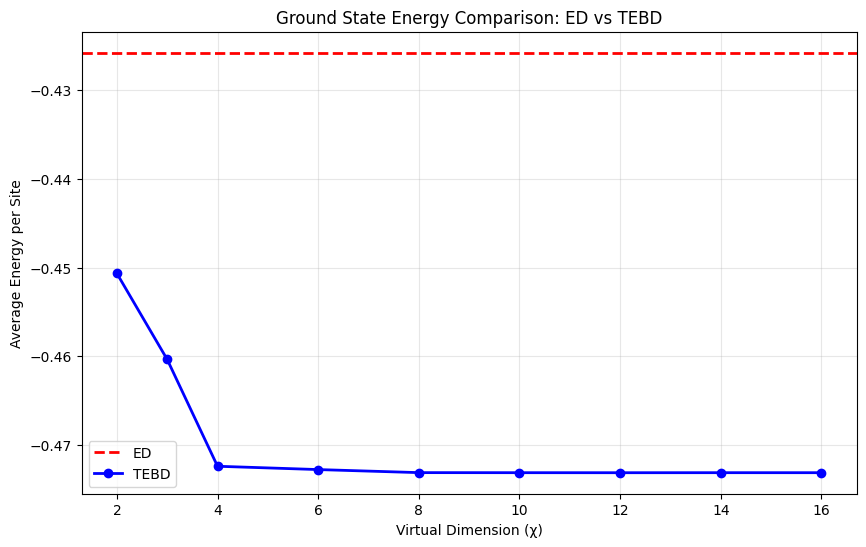

In [20]:
plt.figure(figsize=(10, 6))
plt.axhline(y=avg_energy_ref, color="red", linestyle="--", label="ED", linewidth=2)
plt.plot(
    virtual_dims[: len(avg_energy_tebd)],
    avg_energy_tebd,
    "b-o",
    label="TEBD",
    linewidth=2,
    markersize=6,
)
plt.xlabel("Virtual Dimension (χ)")
plt.ylabel("Average Energy per Site")
plt.title("Ground State Energy Comparison: ED vs TEBD")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()